# Cityscapes image semantic segmentation

In [2]:
import json
import numpy as np
import string
import os
import cv2
from PIL import Image, ImageDraw 
from PIL import ImagePath  
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import utils as u
from keras import losses, optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import multiprocessing
from skimage.util import random_noise, img_as_float
from keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile



class Generator:
    categories ={
"flat": ["road","sidewalk","parking"," rail","track"],
"human":["person","rider"],
"vehicle":["car","truck","bus","on rails","motorcycle","bicycle","caravan","trailer"],
"construction":["building","wall","fence","guard rail","bridge","tunnel"],
"object":["pole", "pole group","traffic sign","traffic light"],
"nature":["vegetation","terrain"],
"sky":["sky"],
"void":["ground", "dynamic" ,"static"]
                }
    
    colors={
        "flat": "grey",
        "human": "red",
        "vehicle": "orange",
        "construction": "brown",
        "object": "black",
        "nature": "green",
        "sky":    "blue",
        "void":   "yellow"
        
    }
    
    cts= {
        "flat":0,
        "human":1,
        "vehicle":2,
        "construction":3,
        "object":4,
        "nature":5,
        "sky":6,
        "void":7
        
    }
    masks=[]
    ims=[]
    
    
    height=512
    width=512
    
    def __init__(self, images, annots):
        self.images=images
        self.annots=annots
        self.subs= list(os.walk(self.images))[0][1]
        self.categories
    
        

    def getNewAnnotations(self):
        cat=[]
        for i in list(os.walk(self.annots)):
            
            if i[0].count(self.annots+"\\test")==0:
                
                if len(i[2])>0:
                    for u in i[2]:
                        if os.path.splitext(u)[1]==".json":
                            
                            with open(i[0]+"\\"+u) as json_file:
                                data = json.load(json_file)
                                im = Image.new(mode = "RGB", size=( data["imgWidth"] ,data["imgHeight"]),color = "white")
                                im1 = ImageDraw.Draw(im) 
                                for obj in data['objects']:
                                    check=False
                                    for cat in self.categories:
                                        
                                        for cl in self.categories[cat]:
                                            if obj['label']==cl:
                                                obj['label']=cat
                                                check=True
                                        
                                    if check==False:
                                        obj['label']="void"
                                    
                                    im1.polygon([val for sublist in obj['polygon'] for val in sublist], fill =self.colors[obj['label']]) 
                                
                                #if os.path.exists("mask"+i[0][6:])==False:
                                   # os.makedirs("mask"+i[0][6:])
                                #im.save("mask"+i[0][6:]+"\\"+os.path.splitext(u)[0][:-16]+".png","PNG")
                                im.save("mask\\"+os.path.splitext(u)[0][:-16]+".png","PNG")
    
    
    def setImages(self):
        for i in list(os.walk("mask")):
            if len(i[2])>0:
                    for u in i[2]:
                        maskp=i[0]+"\\"+u
                        imagep= maskp.replace("mask","leftImg8bit")
                        imagep=imagep.replace(".png", "_leftImg8bit.png")
                        im = Image.open(imagep)
                        
                        im.save("imagesOnly\\"+u)
                        
    
    def resizeImages(self,path):
        for i in list(os.walk("mask")):
            if len(i[2])>0:
                    for u in i[2]:
                        maskp=i[0]+"\\"+u
                        imagep= maskp.replace("mask","leftImg8bit")
                        imagep=imagep.replace(".png", "_leftImg8bit.png")
                        im = Image.open(maskp)
                        im.thumbnail((self.height, self.width), Image.ANTIALIAS)
                        im.save("maskResized\\"+u)
                        im = Image.open(imagep)
                        im.thumbnail((self.height, self.width), Image.ANTIALIAS)
                        im.save("imageResized\\"+u)
                        
       
    def getImages(self, size): 
        for i in list(os.walk("imagesOnly")):
            if len(i[2])>0:
                for u in i[2]:
                    
                    #image = Image.open("imagesOnly\\"+u)
                    image = cv2.imread("imagesOnly\\"+u)
                    image=cv2.resize(image,size)
                    data = np.asarray(image)
                    
                    self.ims.append(data)   
                    
                    
    def getMasks2(self): 
        for i in list(os.walk("maskResized")):
            if len(i[2])>0:
                for u in i[2]:
                    image = cv2.imread("maskResized\\"+u)
                    # image = Image.open("maskResized\\"+u).convert('LA')
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    data = np.asarray(image)
                    data=np.expand_dims(data, axis = -1)
                    self.masks.append(data)   
        
       
    def getRegions(self):
        
        for i in list(os.walk(self.annots)):
            
            if i[0].count(self.annots+"\\test")==0:
                
                if len(i[2])>0:
                    for u in i[2]:
                        if os.path.splitext(u)[1]==".json":
                            copyfile(i[0]+"\\"+u, "regions\\"+u)
                            
                            
    def getMasksR(self,size):
        for i in list(os.walk("regions")):
            for u in i[2]:
                with open("regions\\"+u) as json_file:
                    data = json.load(json_file)
                    im = np.zeros((1024,2048,1),dtype=np.uint8)
                    for obj in data['objects']:
                        check=False
                        for cat in self.categories:
                                        
                            for cl in self.categories[cat]:
                                if obj['label']==cl:
                                    obj['label']=cat
                                    check=True
                                        
                        if check==False:
                            obj['label']="void"
                        pol= np.array([obj['polygon']], dtype=np.int32 )#att[obj['polygon']]
                                    
                        cv2.fillPoly( im, pol, self.cts.get(obj['label']))
                           
                im=cv2.resize(im,size)
                im=np.expand_dims(im, axis = -1) 
                self.masks.append(im)
                
        '''        
    def getMasks(self,size):
        
        for i in list(os.walk(self.annots)):
            
            if i[0].count(self.annots+"\\test")==0:
                
                if len(i[2])>0:
                    for u in i[2]:
                        if os.path.splitext(u)[1]==".json":
                           
                            with open(i[0]+"\\"+u) as json_file:
                                data = json.load(json_file)
                                im = np.zeros((1024,2048,1),dtype=np.uint8)
                                for obj in data['objects']:
                                    check=False
                                    for cat in self.categories:
                                        
                                        for cl in self.categories[cat]:
                                            if obj['label']==cl:
                                                obj['label']=cat
                                                check=True
                                        
                                    if check==False:
                                        obj['label']="void"
                                    pol= np.array([obj['polygon']], dtype=np.int32 )#att[obj['polygon']]
                                    
                                    cv2.fillPoly( im, pol, self.cts.get(obj['label']))
                           
                            im=cv2.resize(im,size)
                            im=np.expand_dims(im, axis = -1) 
                            self.masks.append(im)
        
    '''
            
    def addColors(self, gg):
        im = np.zeros([gg.shape[0],gg.shape[1],3],dtype=np.uint8)

        for i in range(gg.shape[0]):
    
             for u in range(gg.shape[1]):
       
                if gg[i,u]==7:
                        im[i,u]= np.array([255,255,0])
                if gg[i,u]==6:
                        im[i,u]=np.array([0,191,255])
                if gg[i,u]==4:
                        im[i,u]=np.array([0, 0, 0])#black
                if gg[i,u]==5:
                        im[i,u]=np.array([0,128,0])#green
                if gg[i,u]==3:
                        im[i,u]=np.array([205,133,63])
                if gg[i,u]==2:
                        im[i,u]=np.array([255,165,0])
                if gg[i,u]==1:
                        im[i,u]=np.array([255,69,0])
                if gg[i,u]==0:
                        im[i,u]=np.array([128,128,128])
        return im
    
    def compareMasks(self, numbers, model):
        for number in numbers:
            s=model.predict(np.expand_dims(X_test[number], axis = 0))
            check = np.zeros((256, 256), dtype=np.uint8)
            for i in range(0, len(s[0])):
                
                check[i]= np.argmax(s[0][i], axis = 1)
            ss= g.addColors(check)
            mm= g.addColors(Y_test[number])
            f, axarr = plt.subplots(1,2)
            ax1=axarr[0].imshow(ss)
            ax2=axarr[1].imshow(mm)
            
            
            



Using TensorFlow backend.


In [3]:
class Models:
    
    
   
        

    def dice_coef_loss(self,y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
        return 1-((2. * intersection + 1) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + 1))
        
    
    
    
    
    def loss(self,y_true, y_pred):
        numerator = 2 * np.sum(y_true * y_pred, axis=-1)
        denominator = np.sum(y_true + y_pred, axis=-1)
        
        return (1 - (numerator + 1) / (denominator + 1))
        

    
    def Baseline(self, inputDims,loss):
        inputs = Input(inputDims)#((128, 256, 3))
        s = Lambda(lambda x: x / 255) (inputs)
        x = Conv2D(64, (3, 3), padding='same')(s)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(8, (1, 1), padding="valid")(x)

        x = Activation("softmax")(x)
        model = Model(inputs, x)
        model.compile(
            loss=loss, optimizer='adadelta', metrics=["accuracy"])
        
        print(model.summary())
        return model
    
    
    def Unet(self, inputDims, loss):
        inputs = Input(inputDims)
        s = Lambda(lambda x: x / 255) (inputs)

        c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
        c1 = Dropout(0.1) (c1)
        c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
        p1 = MaxPooling2D((2, 2)) (c1)

        c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
        c2 = Dropout(0.1) (c2)
        c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
        p2 = MaxPooling2D((2, 2)) (c2)

        c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
        c3 = Dropout(0.2) (c3)
        c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
        p3 = MaxPooling2D((2, 2)) (c3)

        c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
        c4 = Dropout(0.2) (c4)
        c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

        c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
        c5 = Dropout(0.3) (c5)
        c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
        u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
        c6 = Dropout(0.2) (c6)
        c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

        u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
        c7 = Dropout(0.2) (c7)
        c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

        u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
        c8 = Dropout(0.1) (c8)
        c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

        u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
        u9 = concatenate([u9, c1], axis=3)
        c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
        c9 = Dropout(0.1) (c9)
        c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

        outputs = Conv2D(8, (1, 1), activation='softmax') (c9)

        model = Model(inputs=[inputs], outputs=[outputs])
        model.compile(optimizer='adam', loss=loss,metrics=['accuracy'])
        model.summary()
        return model
    
    def fcn(self, dimentions,loss):
        IMAGE_ORDERING = 'channels_last'
        n_classes=8

        inputs = Input(dimentions)
        s = Lambda(lambda x: x / 255) (inputs)

        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(s)
        x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
        f1 = x
# Block 2
        x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
        f2 = x

# Block 3
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
        f3 = x
        pred3= Conv2DTranspose( n_classes , kernel_size=(16,16) ,  strides=(16,16) , use_bias=False ,  data_format=IMAGE_ORDERING )(f3)

# Block 4
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)
        f4 = x

        pred4= Conv2DTranspose( n_classes , kernel_size=(32,32) ,  strides=(32,32) , use_bias=False ,  data_format=IMAGE_ORDERING )(f4)

# Block 5
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)
        f5 = x
        pred5= Conv2DTranspose( n_classes , kernel_size=(64,64) ,  strides=(64,64) , use_bias=False ,  data_format=IMAGE_ORDERING )(f5)


        o = Add(name="add")([pred3, pred4, pred5])

        o = MaxPooling2D((2, 2), strides=(2, 2), name='final', data_format=IMAGE_ORDERING )(o)
        o = ( Conv2D( n_classes ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
#o = Conv2DTranspose( n_classes , kernel_size=(32,32) ,  strides=(32,32) , use_bias=False ,  data_format=IMAGE_ORDERING )(o)
    
        o = (Activation('softmax'))(o)
        model = Model([inputs] , [o] )
        model.compile(
            loss=dice_coef_loss, optimizer='adam', metrics=["accuracy"])
        print(model.summary())
        return model
    
    
    def Pyramid( self, dimentions,loss):
        
        inputs = Input(dimentions)
        s = Lambda(lambda x: x / 255) (inputs)

    # Encoder
        x = Conv2D(64, (3, 3), padding='same')(s)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    
        x = Conv2D(128, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    
        x = Conv2D(256,( 3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    
        x = Conv2D(512, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
    # Decoder
        x = Conv2D(512, (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(256, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(128, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
        x = Conv2D(8, (1, 1), padding="valid")(x)
#x = Reshape((128*256, 8))(x)
        x = Activation("softmax")(x)
        model = Model(inputs, x)
        model.compile(
            loss=loss, optimizer='adam', metrics=["accuracy"])
        print(model.summary())
        return model


# Preparing the data

In [4]:
g= Generator("leftImg8bit","gtFine")

In [4]:
#setting new masks

#g.getNewAnnotations()

In [5]:
#adding corresponding images original resolution
#g.setImages()

In [6]:
#g.getRegions()

In [7]:
#g.setImages()

In [5]:
g.getMasksR((256,256))
g.getImages((256,256))
print(len(g.masks))
print(len(g.ims))

3475
3475


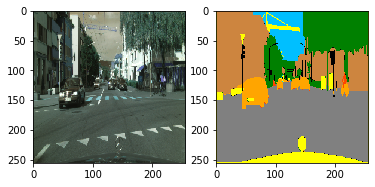

In [6]:
f, axarr = plt.subplots(1,2)
ax1=axarr[0].imshow(g.ims[len(g.ims)-1])
ax2=axarr[1].imshow(g.addColors(g.masks[len(g.masks)-1]))


In [7]:
X = np.zeros((3475, 256, 256, 3), dtype=np.uint8)
Y = np.zeros((3475, 256, 256, 1), dtype=np.uint8)
for i in range(0,3475):
    Y[i]=np.array(g.masks[i])
    X[i]=np.array(g.ims[i])

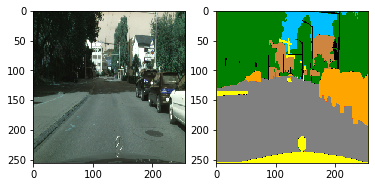

In [8]:
'''
X=np.concatenate((X,X[1000:2000]))
Y=np.concatenate((Y,Y[1000:2000]))
print(len(X))
print(len(Y))
'''
f, axarr = plt.subplots(1,2)
ax1=axarr[0].imshow(X[len(X)-2])
ax2=axarr[1].imshow(g.addColors(Y[len(Y)-2]))


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [10]:
print("Training set")
print("X: "+str(len(X_train)))
print("Y: "+str(len(X_train)))
print("Testing set")
print("X: "+str(len(X_test)))
print("Y: "+str(len(X_test)))

Training set
X: 3127
Y: 3127
Testing set
X: 348
Y: 348


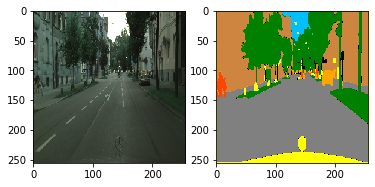

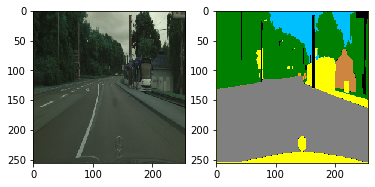

In [11]:
f, axarr = plt.subplots(1,2)
ax1=axarr[0].imshow(X_train[len(X_train)-1])
ax2=axarr[1].imshow(g.addColors(Y_train[len(Y_train)-1]))
f, axarr = plt.subplots(1,2)
ax1=axarr[0].imshow(X_test[len(X_test)-1])
ax2=axarr[1].imshow(g.addColors(Y_test[len(Y_test)-1]))

In [12]:
def dice_coef_loss(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return 1-((2. * intersection + 1) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + 1))

def noise1(img):
    img1= random_noise(np.array(img,dtype = 'uint8'),  mode="gaussian", var=0.001 )
    img2= np.array(255*img1, dtype = 'uint8')
    img3=img2.astype(int)
    return img3

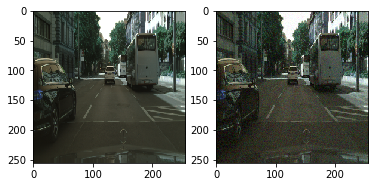

In [13]:
f, axarr = plt.subplots(1,2)
ax1=axarr[0].imshow(X_train[len(X_train)-3])
ax2=axarr[1].imshow(noise1(X_train[len(X_train)-3]))

# Baseline model
- Selecting loss function
- Investingating image augmentation methods

In [13]:

oModels= Models()
baseline=oModels.Baseline(( 256,256, 3),dice_coef_loss)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       520       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 8)       0     

In [14]:
%time
baseline.fit(X_train,to_categorical(Y_train, num_classes=8),epochs=20, batch_size=32, validation_split=0.1,workers=multiprocessing.cpu_count())

Wall time: 0 ns
Train on 2814 samples, validate on 313 samples
Epoch 1/20
2814/2814 [==============================] - 176s 63ms/sample - loss: 0.4268 - accuracy: 0.1381 - val_loss: 0.4107 - val_accuracy: 0.3032
Epoch 2/20
2814/2814 [==============================] - 175s 62ms/sample - loss: 0.4259 - accuracy: 0.1425 - val_loss: 0.4116 - val_accuracy: 0.2268
Epoch 3/20
2814/2814 [==============================] - 176s 62ms/sample - loss: 0.4251 - accuracy: 0.1471 - val_loss: 0.4128 - val_accuracy: 0.1899
Epoch 4/20
2814/2814 [==============================] - 176s 63ms/sample - loss: 0.4241 - accuracy: 0.1508 - val_loss: 0.4143 - val_accuracy: 0.1762
Epoch 5/20
2814/2814 [==============================] - 177s 63ms/sample - loss: 0.4231 - accuracy: 0.1548 - val_loss: 0.4162 - val_accuracy: 0.1729
Epoch 6/20
2814/2814 [==============================] - 176s 63ms/sample - loss: 0.4221 - accuracy: 0.1589 - val_loss: 0.4178 - val_accuracy: 0.1740
Epoch 7/20
2814/2814 [=====================

In [15]:
baseline.evaluate(X_test, to_categorical(Y_test,num_classes=8), verbose=0)

[0.40786632518658694, 0.26529738]

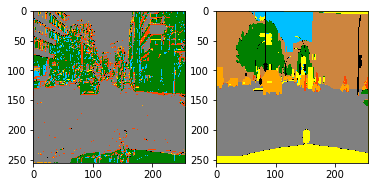

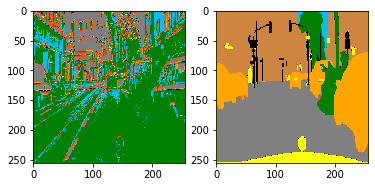

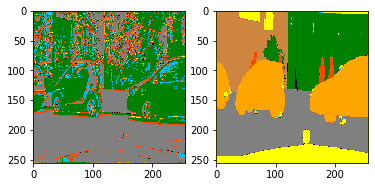

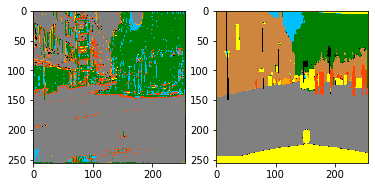

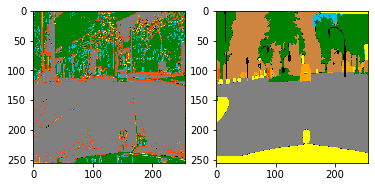

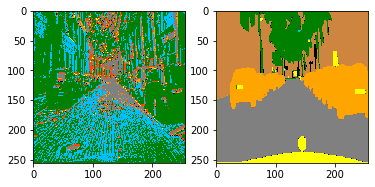

In [17]:
g.compareMasks([73,100,34, 247, 165, 23],baseline)

In [18]:
%time
oModels= Models()
baseline=oModels.Baseline((256, 256, 3),losses.sparse_categorical_crossentropy)
baseline.fit(X_train,Y_train,epochs=20, batch_size=32, validation_split=0.1)

Wall time: 0 ns
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 8)       520       
_________________________________________________________________
activation_3 (Activation)    (None, 256, 25

In [19]:
baseline.evaluate(X_test, Y_test, verbose=0)

[1.9779972523108296, 0.20657884]

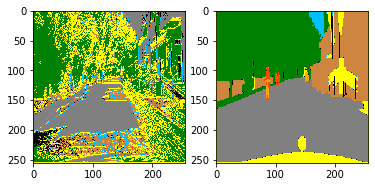

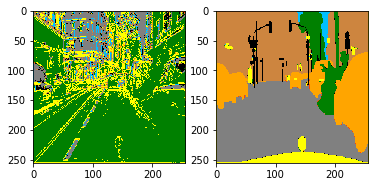

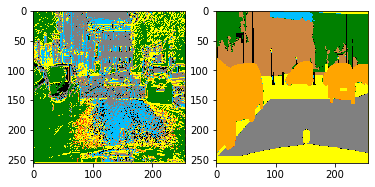

In [20]:
g.compareMasks([72,100,203],baseline)

In [21]:
%time
oModels= Models()
baseline=oModels.Baseline((256,256, 3),dice_coef_loss)

# initialize the number of epochs and batch size
EPOCHS = 20
BS = 32
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=15, zoom_range=0.25, preprocessing_function= noise1)
# train the network
baseline.fit(aug.flow(X_train, to_categorical(Y_train), batch_size=BS),
validation_data=(X_test, to_categorical(Y_test)), steps_per_epoch=len(X_train) // BS,
epochs=EPOCHS,workers=multiprocessing.cpu_count())


Wall time: 0 ns
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_4 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 8)       520       
_________________________________________________________________
activation_5 (Activation)    (None, 256, 25

In [22]:
baseline.evaluate(X_test, to_categorical(Y_test, num_classes=8), verbose=0)

[0.3906268124607788, 0.29241663]

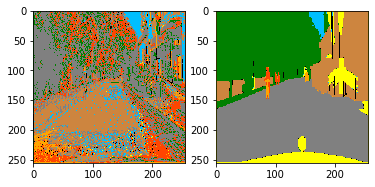

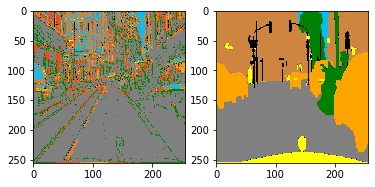

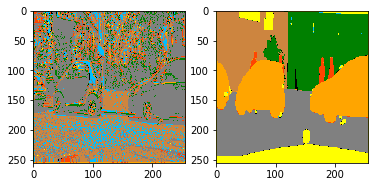

In [23]:
g.compareMasks([72,100,34],baseline)

In [ ]:

def dice_loss(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + 100) / (sum_ - intersection + 100)
    return (1 - jac) * 100

# Unet
- using dice coeficient as loss function
- training a model with and without image augumentation

In [31]:
var = Models()#losses.sparse_categorical_crossentropy dice_coef_loss
unet=var.Unet((256, 256, 3),dice_coef_loss)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 256, 256, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

In [26]:


from keras.utils import to_categorical
import multiprocessing

from keras.preprocessing.image import ImageDataGenerator
# train the network
%time
aug = ImageDataGenerator(rotation_range=10, zoom_range=0.15,preprocessing_function= noise1)
#aug.flow(X_train, to_categorical(Y_train, num_classes=8), batch_size=BS)
unet.fit(aug.flow(X_train, to_categorical(Y_train, num_classes=8), batch_size=10),
validation_data=(X_test, to_categorical(Y_test,num_classes=8)),
epochs=50,workers=multiprocessing.cpu_count())

Wall time: 0 ns
Train for 313 steps, validate on 348 samples
Epoch 1/50
313/313 [==============================] - 541s 2s/step - loss: 0.1413 - accuracy: 0.7589 - val_loss: 0.1570 - val_accuracy: 0.7309
Epoch 2/50
313/313 [==============================] - 530s 2s/step - loss: 0.1283 - accuracy: 0.7816 - val_loss: 0.1357 - val_accuracy: 0.7723
Epoch 3/50
313/313 [==============================] - 528s 2s/step - loss: 0.1222 - accuracy: 0.7914 - val_loss: 0.1389 - val_accuracy: 0.7667
Epoch 4/50
313/313 [==============================] - 528s 2s/step - loss: 0.1182 - accuracy: 0.7975 - val_loss: 0.1218 - val_accuracy: 0.7919
Epoch 5/50
313/313 [==============================] - 528s 2s/step - loss: 0.1150 - accuracy: 0.8023 - val_loss: 0.1189 - val_accuracy: 0.7979
Epoch 6/50
313/313 [==============================] - 527s 2s/step - loss: 0.1139 - accuracy: 0.8041 - val_loss: 0.1110 - val_accuracy: 0.8095
Epoch 7/50
313/313 [==============================] - 528s 2s/step - loss: 0.1091

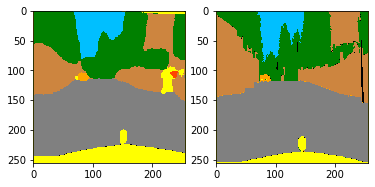

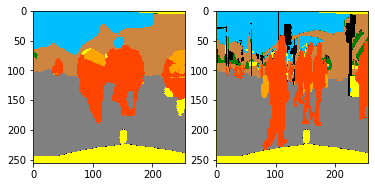

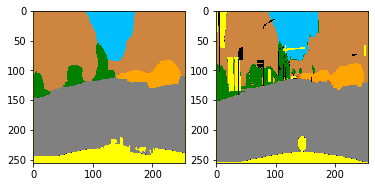

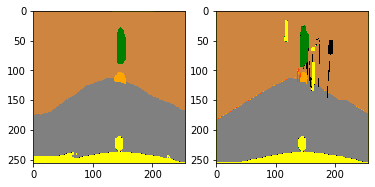

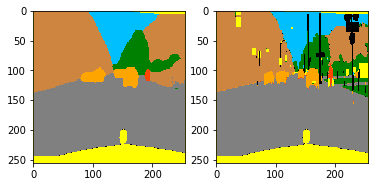

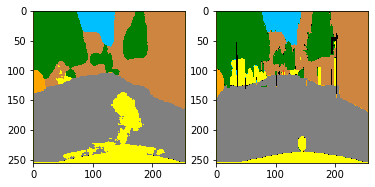

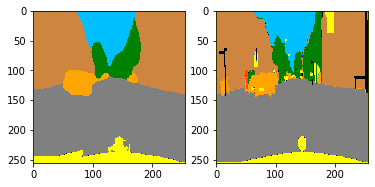

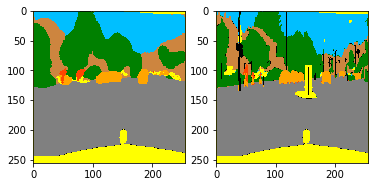

In [27]:
g.compareMasks([10,22,222,182,166,299,55, 62],unet)

In [29]:
unet.evaluate(X_test, to_categorical(Y_test, num_classes=8), verbose=0)

[0.09036121877103016, 0.84609896]

In [30]:
model_json = unet.to_json()
with open("model1aug.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
unet.save_weights("model1aug.h5")

In [32]:
unet.compile(
            optimizer='adam',
            loss=dice_coef_loss ,#dice_coef_loss losses.sparse_categorical_crossentropy
            metrics=['accuracy'])
print(unet.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 256, 256, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

In [33]:
%time


unet.fit(X_train, to_categorical(Y_train,num_classes=8),
validation_data=(X_test, to_categorical(Y_test,num_classes=8)),
epochs=50,workers=multiprocessing.cpu_count())

Wall time: 0 ns
Train on 3127 samples, validate on 348 samples
Epoch 1/50
3127/3127 [==============================] - 463s 148ms/sample - loss: 0.2303 - accuracy: 0.5964 - val_loss: 0.2262 - val_accuracy: 0.6199
Epoch 2/50
3127/3127 [==============================] - 458s 146ms/sample - loss: 0.1356 - accuracy: 0.7701 - val_loss: 0.1473 - val_accuracy: 0.7544
Epoch 3/50
3127/3127 [==============================] - 456s 146ms/sample - loss: 0.1118 - accuracy: 0.8128 - val_loss: 0.1351 - val_accuracy: 0.7723
Epoch 4/50
3127/3127 [==============================] - 456s 146ms/sample - loss: 0.1006 - accuracy: 0.8319 - val_loss: 0.1157 - val_accuracy: 0.8078
Epoch 5/50
3127/3127 [==============================] - 456s 146ms/sample - loss: 0.0940 - accuracy: 0.8426 - val_loss: 0.1150 - val_accuracy: 0.8098
Epoch 6/50
3127/3127 [==============================] - 456s 146ms/sample - loss: 0.0886 - accuracy: 0.8516 - val_loss: 0.0994 - val_accuracy: 0.8347
Epoch 7/50
3127/3127 [===============

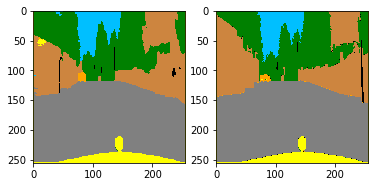

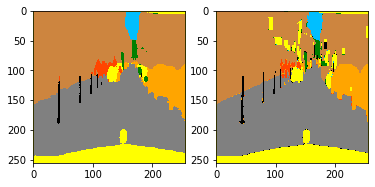

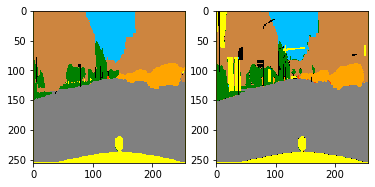

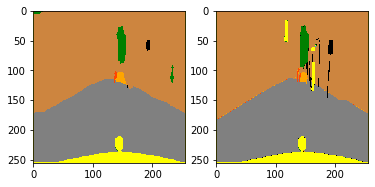

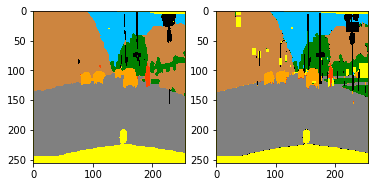

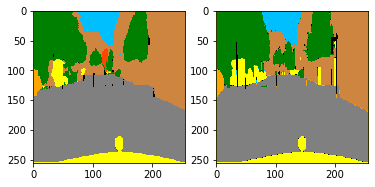

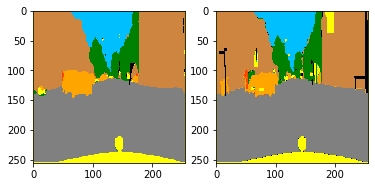

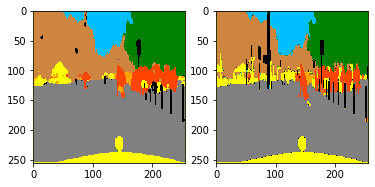

In [37]:
g.compareMasks([10,220,222,182,166,299,55, 28],unet)

In [38]:
unet.evaluate(X_test, to_categorical(Y_test, num_classes=8), verbose=0)

[0.05834005563252274, 0.9014312]

In [39]:
model_json = unet.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
unet.save_weights("model1.h5")

### Fully Convolutional Network

In [51]:
var= Models()
fcn=var.fcn((256, 256, 3),dice_coef_loss)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 256, 256, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        lambda_8[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
____________________________________________________________________________________________

In [52]:
%time


fcn.fit(X_train, to_categorical(Y_train,num_classes=8),
validation_data=(X_test, to_categorical(Y_test,num_classes=8)),
epochs=50,workers=multiprocessing.cpu_count())

Wall time: 0 ns
Train on 3127 samples, validate on 348 samples
Epoch 1/50
3127/3127 [==============================] - 1171s 374ms/sample - loss: 0.2791 - accuracy: 0.5158 - val_loss: 0.2101 - val_accuracy: 0.6466
Epoch 2/50
3127/3127 [==============================] - 1163s 372ms/sample - loss: 0.1640 - accuracy: 0.7239 - val_loss: 0.1621 - val_accuracy: 0.7256
Epoch 3/50
3127/3127 [==============================] - 1151s 368ms/sample - loss: 0.1407 - accuracy: 0.7641 - val_loss: 0.1241 - val_accuracy: 0.7918
Epoch 4/50
3127/3127 [==============================] - 1152s 368ms/sample - loss: 0.1137 - accuracy: 0.8095 - val_loss: 0.1036 - val_accuracy: 0.8262
Epoch 5/50
3127/3127 [==============================] - 1150s 368ms/sample - loss: 0.1016 - accuracy: 0.8298 - val_loss: 0.0976 - val_accuracy: 0.8356
Epoch 6/50
3127/3127 [==============================] - 1149s 367ms/sample - loss: 0.0916 - accuracy: 0.8465 - val_loss: 0.0856 - val_accuracy: 0.8561
Epoch 7/50
3127/3127 [=========

In [55]:
fcn.evaluate(X_test, to_categorical(Y_test, num_classes=8), verbose=0)

[0.0599112112032271, 0.8987983]

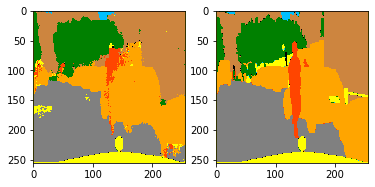

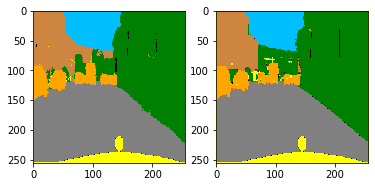

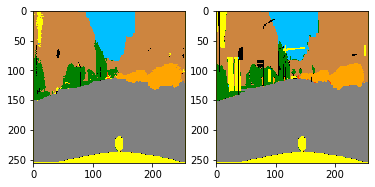

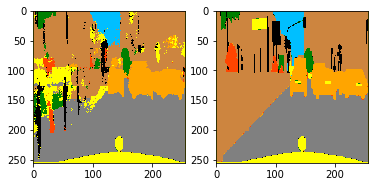

In [56]:
g.compareMasks([4,123,222, 200],fcn)

In [57]:
model_json = fcn.to_json()
with open("modelFcn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
fcn.save_weights("modelFcn.h5")

In [18]:
#FcN augumented
%time
var= Models()
fcn=var.Unet((256, 256, 3),dice_coef_loss)
aug = ImageDataGenerator(rotation_range=10, zoom_range=0.15,preprocessing_function= noise1)
fcn.fit(aug.flow(X_train, to_categorical(Y_train, num_classes=8), batch_size=10),
validation_data=(X_test, to_categorical(Y_test,num_classes=8)),
epochs=50,workers=multiprocessing.cpu_count())

Wall time: 0 ns
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________

Train for 313 steps, validate on 348 samples
Epoch 1/50
313/313 [==============================] - 533s 2s/step - loss: 0.1899 - accuracy: 0.6709 - val_loss: 0.1839 - val_accuracy: 0.6924
Epoch 2/50
313/313 [==============================] - 524s 2s/step - loss: 0.1367 - accuracy: 0.7673 - val_loss: 0.1306 - val_accuracy: 0.7802
Epoch 3/50
313/313 [==============================] - 524s 2s/step - loss: 0.1261 - accuracy: 0.7855 - val_loss: 0.1089 - val_accuracy: 0.8152
Epoch 4/50
313/313 [==============================] - 523s 2s/step - loss: 0.1214 - accuracy: 0.7929 - val_loss: 0.0999 - val_accuracy: 0.8298
Epoch 5/50
313/313 [==============================] - 523s 2s/step - loss: 0.1177 - accuracy: 0.7984 - val_loss: 0.1103 - val_accuracy: 0.8111
Epoch 6/50
313/313 [==============================] - 523s 2s/step - loss: 0.1149 - accuracy: 0.8025 - val_loss: 0.0953 - val_accuracy: 0.8392
Epoch 7/50
313/313 [==============================] - 523s 2s/step - loss: 0.1120 - accuracy: 0.8

In [19]:
fcn.evaluate(X_test,to_categorical(Y_test,num_classes=8), verbose=0)

[0.08074026392109093, 0.86069447]

In [20]:
model_json = fcn.to_json()
with open("modelFCNAug.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
fcn.save_weights("modelFCNAug.h5")

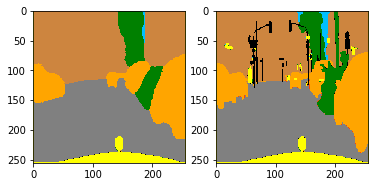

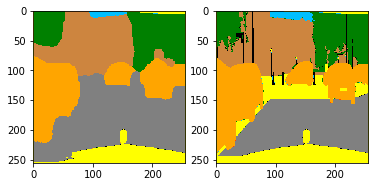

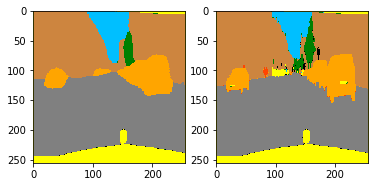

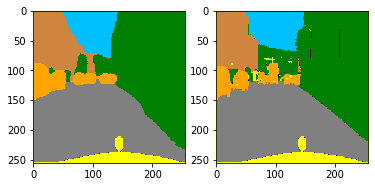

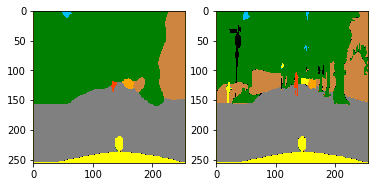

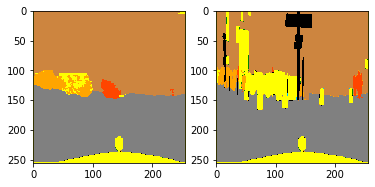

In [21]:
g.compareMasks([100,203,221,123,224,99],fcn)

In [14]:
var = Models()
pyramid= var.Pyramid((256, 256, 3),dice_coef_loss)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856 

In [15]:
%time

aug = ImageDataGenerator(rotation_range=10, zoom_range=0.10,horizontal_flip=True,preprocessing_function= noise1)
#aug.flow(X_train, to_categorical(Y_train, num_classes=8), batch_size=BS)
pyramid.fit(X_train, to_categorical(Y_train,num_classes=8),
validation_data=(X_test, to_categorical(Y_test,num_classes=8)), 
epochs=50,workers=multiprocessing.cpu_count())

Wall time: 0 ns
Train on 3127 samples, validate on 348 samples
Epoch 1/50
3127/3127 [==============================] - 2217s 709ms/sample - loss: 0.1404 - accuracy: 0.7592 - val_loss: 0.3666 - val_accuracy: 0.4176
Epoch 2/50
3127/3127 [==============================] - 2213s 708ms/sample - loss: 0.1050 - accuracy: 0.8202 - val_loss: 0.3841 - val_accuracy: 0.4073
Epoch 3/50
3127/3127 [==============================] - 2213s 708ms/sample - loss: 0.0969 - accuracy: 0.8342 - val_loss: 0.3633 - val_accuracy: 0.4337
Epoch 4/50
3127/3127 [==============================] - 2211s 707ms/sample - loss: 0.0887 - accuracy: 0.8485 - val_loss: 0.3361 - val_accuracy: 0.4595
Epoch 5/50
3127/3127 [==============================] - 2211s 707ms/sample - loss: 0.0834 - accuracy: 0.8575 - val_loss: 0.2017 - val_accuracy: 0.6578
Epoch 6/50
3127/3127 [==============================] - 2212s 707ms/sample - loss: 0.0797 - accuracy: 0.8638 - val_loss: 0.1337 - val_accuracy: 0.7705
Epoch 7/50
3127/3127 [=========

In [16]:
model_json = pyramid.to_json()
with open("modelPyramidAug.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
pyramid.save_weights("modelPyramidAug.h5")

In [17]:
pyramid.evaluate(X_train, to_categorical(Y_train, num_classes=8), verbose=0)

[0.05549765851194957, 0.9044299]

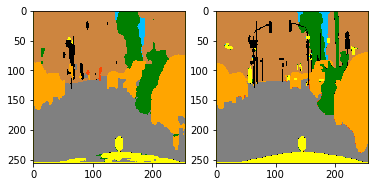

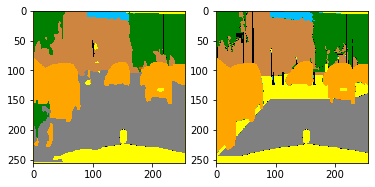

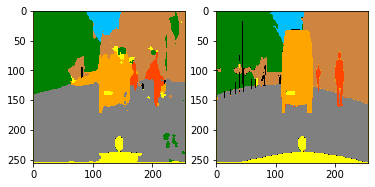

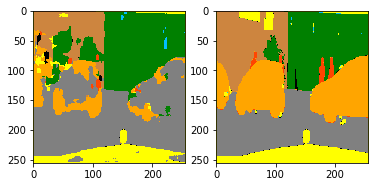

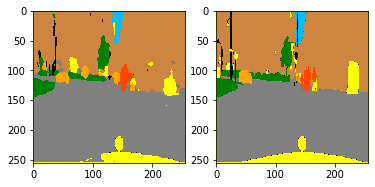

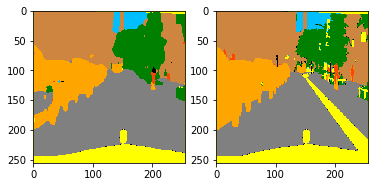

In [18]:
g.compareMasks([100,203,346,34,6,69],pyramid)

In [20]:
%time
pyramid= var.Pyramid((256, 256, 3),dice_coef_loss)
pyramid.fit(X_train, to_categorical(Y_train,num_classes=8),
validation_data=(X_test, to_categorical(Y_test,num_classes=8)),
epochs=50,workers=multiprocessing.cpu_count())

Wall time: 0 ns
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_9 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 12

In [21]:

model_json = pyramid.to_json()
with open("modelPyramid.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
pyramid.save_weights("modelPyramid.h5")


In [22]:
pyramid.evaluate(X_train, to_categorical(Y_train, num_classes=8), verbose=0)


[0.23703301383219932, 0.6208984]

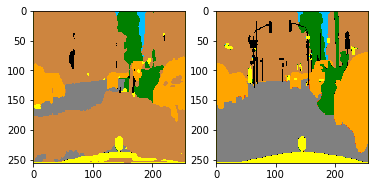

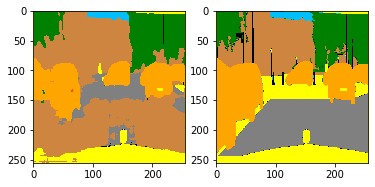

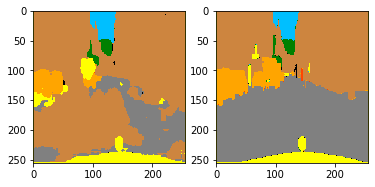

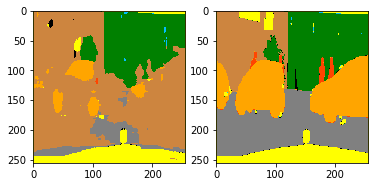

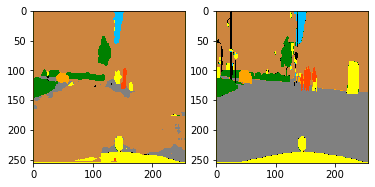

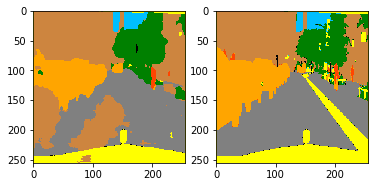

In [23]:
g.compareMasks([100,203,306,34,6,69],pyramid)

# Summary

<table>
    <tr>
            <th>Model</th><th>Accuracy</th><th>Loss</th>
        </tr>
    <tbody>
    <tr>
            <td>U-Net Augmented</td><td>0.846</td><td>0.09</td>
            </tr>
        <tr>
            <td>U-Net</td><td>0.901</td><td>0.058</td>
            </tr><tr>
            <td>Basic</td><td>0.265</td><td>0.408</td>
            </tr><tr><td>Basic Augmented</td><td>0.292</td><td>0.39</td>
            </tr><tr><td>FCN</td><td>0.9</td><td>0.06</td>
            </tr><tr><td>FCN Augumented</td><td>0.861</td><td>0.081</td>
            </tr><tr><td>Pyramid</td><td>0.621</td><td>0.237</td>
    </tr><tr><td><b>Pyramid Augmented</td><td><b>0.904</td><td><b>0.055</td>
        </tr></tbody>
    
</table>